In [68]:
!pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.0.9-py3-none-any.whl size=184112 sha256=945fe61c1aa02edec84bd63757db1523249ef5072177bfe91b5dadcddf932590
  Stored in directory: /root/.cache/pip/wheels/83/55/6b/552e083cf5509c0afe808b76cf434f1be284d01a112623bd37
Successfully built pyod


In [93]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.font_manager
from pyod.models.knn import KNN 
from pyod.utils.data import generate_data, get_outliers_inliers
from sklearn.svm import OneClassSVM  #calculates the number of outliers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from pylab import rcParams

In [36]:
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [37]:
df=pd.read_csv('/content/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [39]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [40]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes

0    284315
1       492
Name: Class, dtype: int64

([<matplotlib.axis.XTick at 0x7f74f0a7c5e0>,
 [Text(0, 0, 'Normal'), Text(1, 0, 'Fraud')])

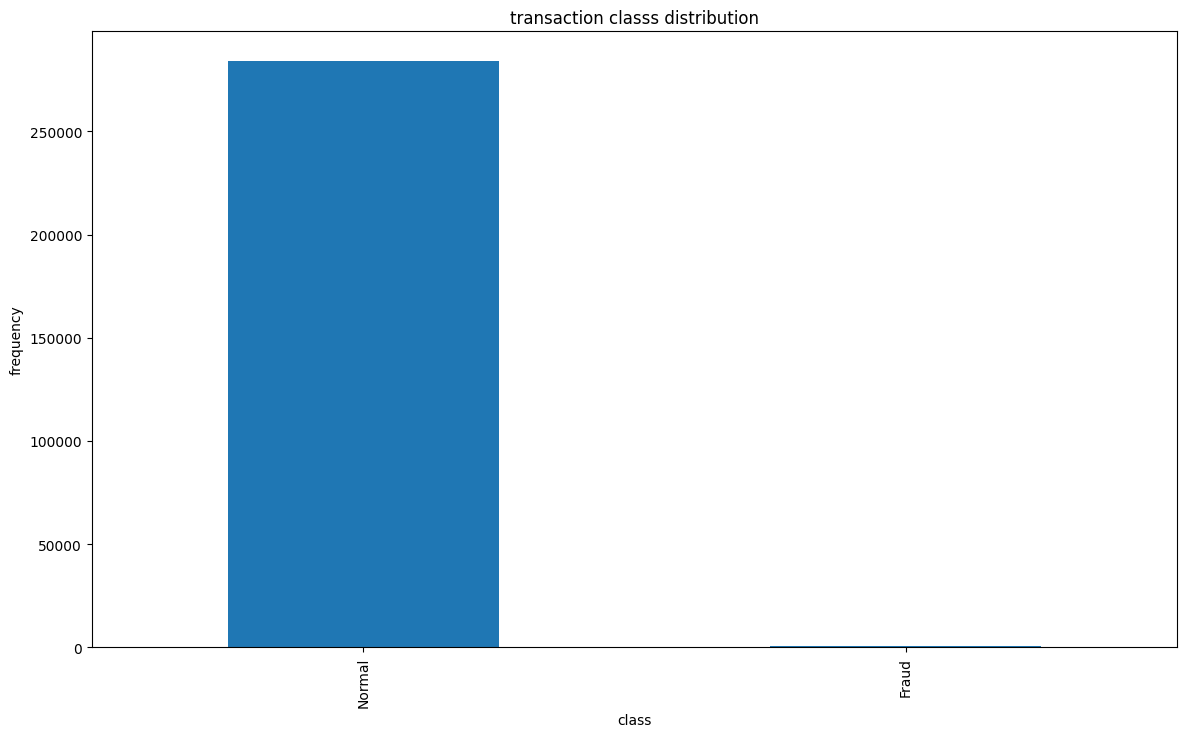

In [41]:
count_classes.plot(kind='bar')
plt.xlabel('class')
plt.ylabel('frequency')
plt.title('transaction classs distribution')
plt.xticks(range(2),LABELS)

In [42]:
# getting fraud and normal dataset
fraud=df[df['Class']==1]
normal=df[df['Class']==0]

In [43]:
fraud.shape

(492, 31)

In [44]:
normal.shape

(284315, 31)

In [45]:
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [46]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

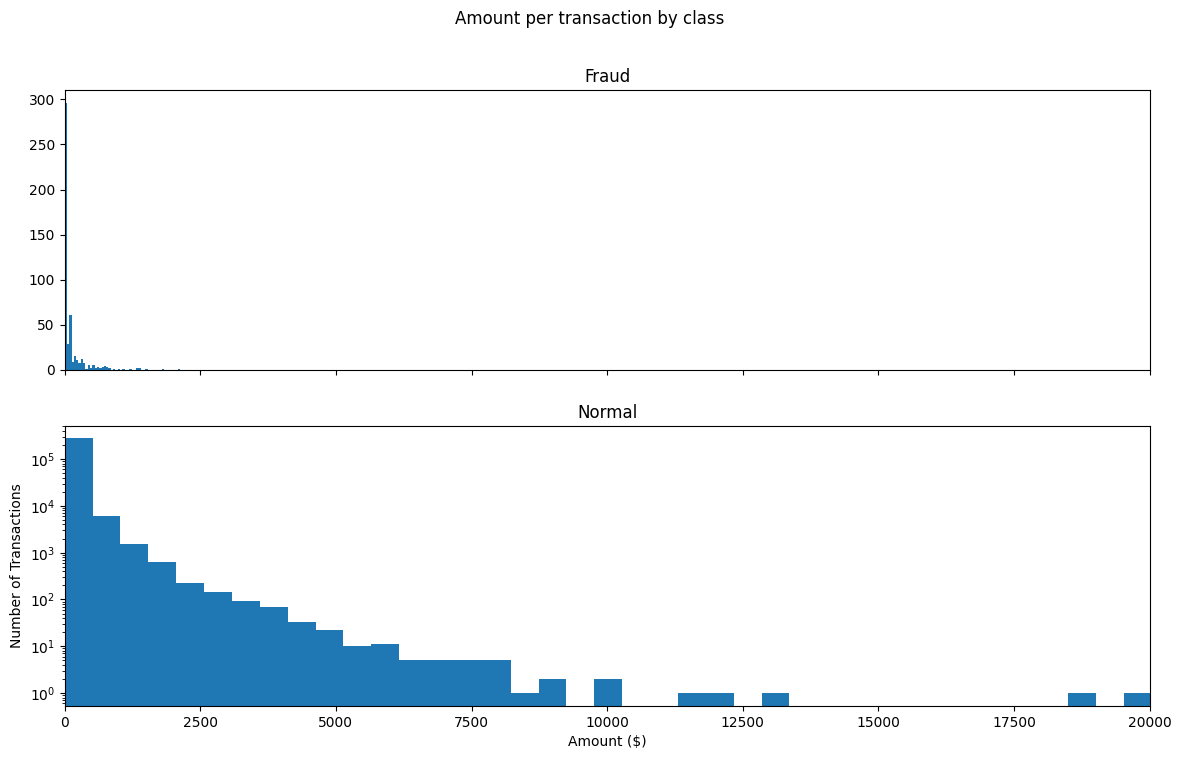

In [47]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

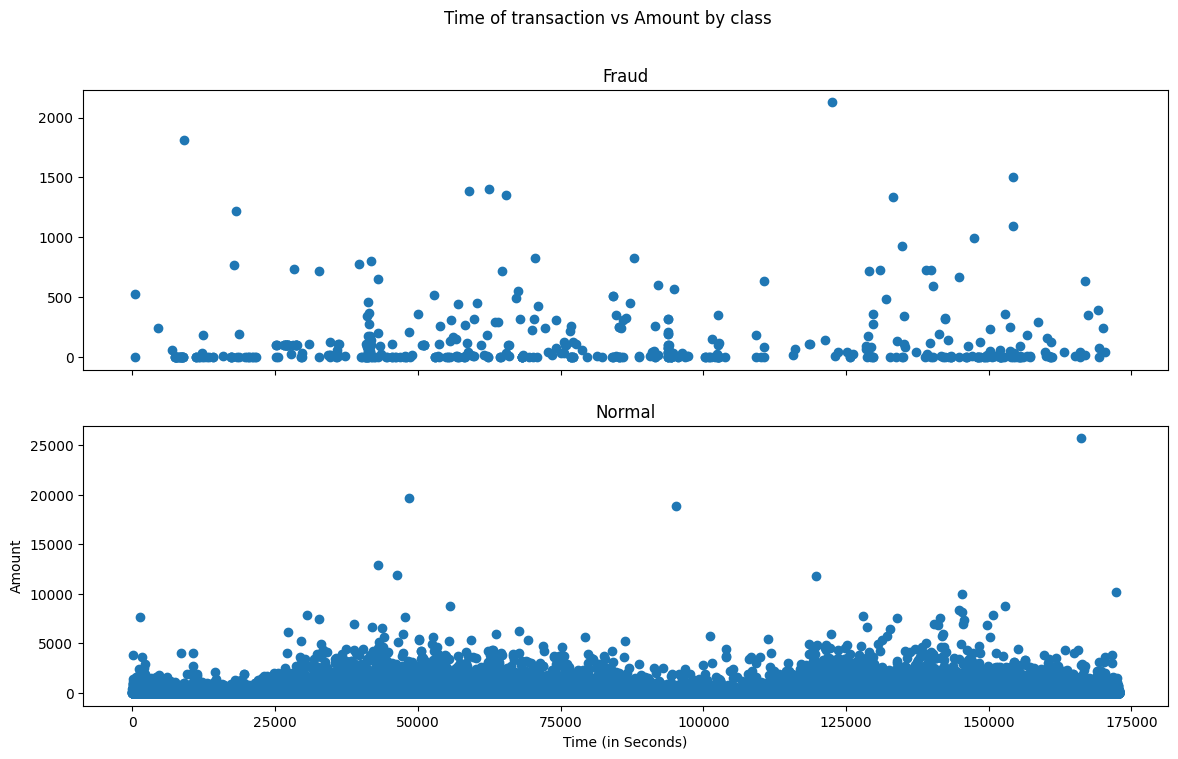

In [48]:
#plotting time vs fraud
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [49]:
df1=df.sample(frac=0.1,random_state=42)
df1

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
43428,41505.0,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,-8.507059,...,1.190739,-1.127670,-2.358579,0.673461,-1.413700,-0.462762,-2.018575,-1.042804,364.19,1
49906,44261.0,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,0.899746,...,-0.213436,-0.942525,-0.526819,-1.156992,0.311211,-0.746647,0.040996,0.102038,520.12,0
29474,35484.0,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,-0.971747,...,0.102398,0.168269,-0.166639,-0.810250,0.505083,-0.232340,0.011409,0.004634,31.00,0
276481,167123.0,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,-0.484715,...,0.358932,0.873663,-0.178642,-0.017171,-0.207392,-0.157756,-0.237386,0.001934,1.50,0
278846,168473.0,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,0.363241,...,-0.238644,-0.616400,0.347045,0.061561,-0.360196,0.174730,-0.078043,-0.070571,0.89,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253684,156360.0,-1.046464,1.850070,-0.617430,-0.936587,0.967356,-0.718273,1.423253,-0.652819,1.350280,...,0.063241,1.270808,-0.160536,0.606343,-0.563656,-0.346759,0.117167,-0.328451,0.89,0
60684,49447.0,-0.397555,0.517869,0.802830,-1.447479,-0.367715,-0.433437,-0.100778,0.276699,-1.695747,...,-0.059047,-0.441186,-0.026409,-0.577948,-0.005708,-0.499793,-0.090677,-0.048393,23.94,0
195432,131048.0,-0.998215,0.549488,0.821957,-2.766061,0.241664,0.549257,-0.185200,0.647442,-1.467094,...,0.191099,0.441847,-0.536822,-0.306352,0.956530,-0.108250,0.126677,0.030180,5.90,0
265273,161812.0,2.063299,0.015015,-1.042161,0.409655,-0.069835,-1.198490,0.243507,-0.385099,0.408691,...,-0.278942,-0.625629,0.331276,0.070205,-0.269826,0.192509,-0.064914,-0.058058,1.29,0


In [50]:
fr=df1[df1['Class']==1]
val=df1[df1['Class']==0]
outlier=len(fr)/float(len(val))
outlier

0.001617724635132759

In [51]:
len(fraud)

492

In [52]:
len(val)

28435

In [53]:
import seaborn as sns

In [54]:
#calculate correlation
cor=df1.corr()
top_corr_features=cor.index
plt.figure(figsize=(20,20))

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

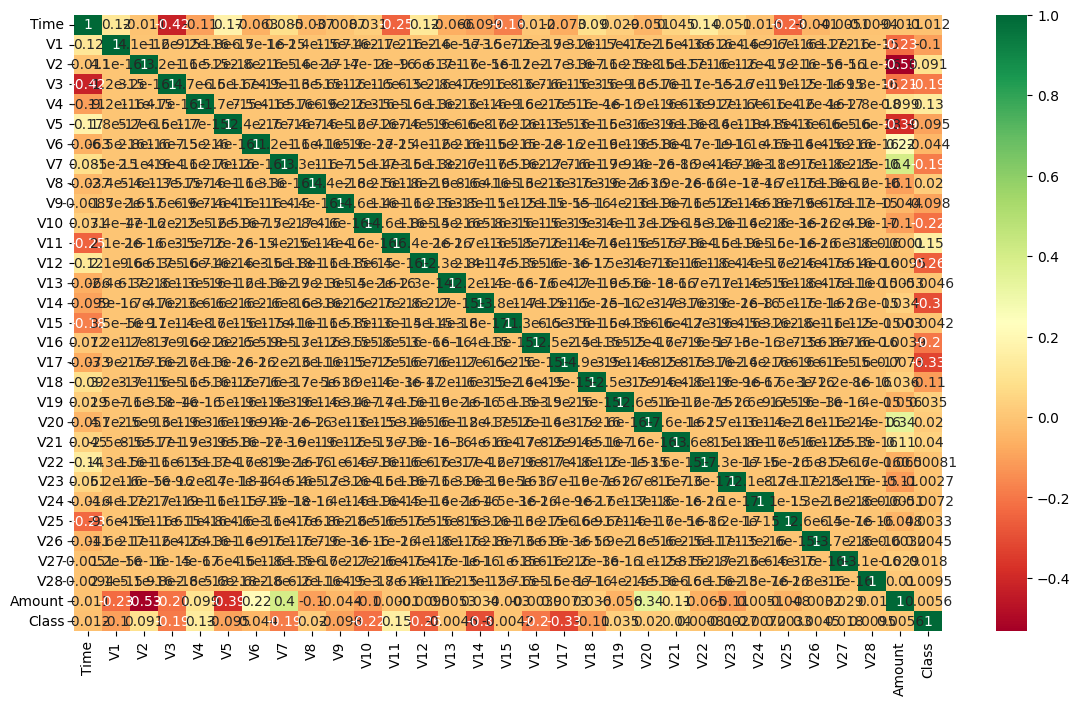

In [55]:
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [56]:
cols=df1.columns.to_list()
print(cols,end=" ")

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'] 

In [105]:
cols=[c for c in cols if c not in ['Class']]
cols

['Time',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount']

In [58]:
target="Class"

In [59]:
#define a random state
state=np.random.RandomState(42)
X=df1[cols]
Y=df1[target]
X_outlier=state.uniform(low=0,high=1,size=(X.shape[0],X.shape[1]))

In [60]:
print(X.shape)
print(Y.shape)

(28481, 30)
(28481,)


In [97]:
from sklearn.neighbors import KNeighborsRegressor

In [103]:
#Define the outlier detection methods

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1)
   
}

In [87]:
type(classifiers)

dict

In [104]:
n_outliers = len(fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)      
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Isolation Forest: 65
Accuracy Score :
0.9977177767634563
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28435
           1       0.30      0.30      0.30        46

    accuracy                           1.00     28481
   macro avg       0.65      0.65      0.65     28481
weighted avg       1.00      1.00      1.00     28481

Local Outlier Factor: 91
Accuracy Score :
0.9968048874688389
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28435
           1       0.02      0.02      0.02        46

    accuracy                           1.00     28481
   macro avg       0.51      0.51      0.51     28481
weighted avg       1.00      1.00      1.00     28481

Support Vector Machine: 9526
Accuracy Score :
0.6655314069028475
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.67   